# GPU Ocean Tutorial - Deterministic Trajectory Forecast

This tutorial will show how to set up and run a deterministic drift trajectory forecast using real-world data.

A breif overview of the most important classes and methods in this respect is given. The tutorial then covers selecting an area and loading boundary- and initial conditions(from norkyst800 and norfjords160), setting up a simulator and observation-instance, adding drifters and running a simulation. It also covers certain basic configurations and how to save, access and plot trajectory results. Saving and accessing data about the state of the underlying ocean model is not included. 

The tutorial demonstrates how to set up a simulation from scratch. At the end, a function to quick-start a customized simulation is introduced.

## Overview of classes and modules


<img src="TutorialDeterministicDrift_CodeFlowDiagram.jpeg" width="500"/>


[comment]: # (Insert jpg file to avoid installing latex/tikz jupyter extension, but is ugly.)

The figure above summarizes key elements when simulating a (deterministic) drift trajectory. Classes and methods are in blue, green represent data-files. 

We now move on to an example. We start by importing the relevant modules and setting the 

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler gpu_ctx

## Selecting area and loading initial- and boundary conditions

As initial and boundary conditions to the simulation, we use data from the Norkyst800 model:

In [4]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
#locally:
#source_url = '/home/johanna/gpu-ocean/gpu_ocean/papers/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

A local file path or URL to a NetCDF-file, or lists of either may be given. 

We need to specify what domain to model and load the data.

  <code> NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1) </code>
    
loads the data relevant for the domain limited by $X[x_0], X[x_1], Y[y_0], Y[y_1]$, where $X$, $Y$ are horizontal position arrays from the given netCDF-file. That is, $x_0, x_1, y_0, y_1$ are indicies into position arrays, which in this case span a $800$m resolution grid. 

Certain areas within the Norkyst-800 model domain are pre-defined. We can use data from these with 

   <code> NetCDFInitialization.getInitialConditionsNorkystCases(source_url, casename)</code>

We choose Lofoten:

In [5]:
casename = 'lofoten'
data_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url,casename, download_data=False)

With <code> NetCDFInitialization.getCaseLocation </code> we get more information about the chosen domain:

In [6]:
NetCDFInitialization.getCaseLocation('lofoten')

{'name': 'lofoten', 'x0': 1400, 'x1': 1900, 'y0': 450, 'y1': 750}

## Creating simulator and forecast

Stripping data_args of unneccessary information with  <code> NetCDFInitialization.removeMetadata</code> it can then be passed to a simulator object along with some additional arguments:

In [7]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
     }

sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


(The calculation domain specified in the NetCDFInitialization (see above) includes a ring of ghost cells (2 cells wide) where the NorKyst800 values are prescribed as Dirichlet data. The interior domain in the ghost cell frame is has an outer ring of 20 width of so-called sponge cells where the relaxation scheme for the nesting is applied.) More arguments can be added to sim_args to control for instance the order of the numerical method, land-erosion configurations etc. These are configurations related to the underlying ocean model. 

We create an observation-object to store the forecast, using parameters from the simulation :

In [8]:
observation_args = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                'nx': sim.nx, 'ny': sim.ny,
                'domain_size_x': sim.nx*sim.dx,
                'domain_size_y': sim.ny*sim.dy,
                'land_mask': sim.getLandMask()
               }

forecast = Observation.Observation(**observation_args)

For objects drifting at sea, UnderlyingFlow is the correct ObservationType.

## Creating drifters

Now we create some drifters. The drifter collection will be attached to the simulation later. This means the simulation of drift trajectories can start at any point during an ongoing ocean model simulation. 

In [9]:
num_drifters = 3
drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                 boundaryConditions = sim.boundary_conditions,
                                                 domain_size_x = forecast.domain_size_x,
                                                 domain_size_y = forecast.domain_size_y,
                                                 gpu_stream = sim.gpu_stream)


We set the drifter positions with <code> .setDrifterPositions</code>:

In [10]:
init_positions = np.array([[196790, 148550],  #[[x1, y1],
                           [217930, 80860],  # [x2, y2],
                           [104890, 146440]]) # [x3, y3]]
drifters.setDrifterPositions(init_positions)

The positions are given in meters from the edge of the domain, which corresponds to 800 times the number of cells into the domain. 

## Running the simulation

<code> Simulator.step(dt) </code> evolves the simulation dt forward in time. Looping over this, we can simulate the ocean using a stepsize dt of our choice and for the number of hours we want(limited by the available boundary-data), attaching drifters and starting the trajectory forecast after a chosen number of hours.

<code> Observation.add_observation_from_sim </code> saves the current positions of drifters to the observation object in each time step. 

Here, we simulate the ocean for 24 hours, adding drifters after the first 5 hours.

In [11]:
start_drifters_hours = 5
total_hours = 24
dt = 5*60 # Stepsize: 5min (in seconds)
timesteps_per_hour = int(60*60 / dt)

#Create progress bar
progress = Common.ProgressPrinter(5)
pp = display(progress.getPrintString(0), display_id=True)

#Run simulation
for hour in range(total_hours):
    
    if hour == start_drifters_hours:                  #Attach drifters 
        sim.attachDrifters(drifters)
        forecast.add_observation_from_sim(sim)
    
    for n in range(timesteps_per_hour):    
        t = sim.step(dt)                              #make one step forward in time
        if hour >= start_drifters_hours:               #Add positions to observation only if drifters have been attached
            forecast.add_observation_from_sim(sim) 
    
    #Update progress bar
    pp.update(progress.getPrintString(hour/(total_hours-1)))

'0% [##############################] 100%. Total: 31s, elapsed: 31s, remaining: 0s'

## Saving trajectories to file

The observation class provides functions <code>.to_pickle</code> and <code>.read_pickle</code> to easily write and read trajectory info to and from file. 

In [12]:
filename = 'tutorial_forecast_'+str(start_drifters_hours)+'_to_'+str(total_hours)+'.pickle'

#Save data
forecast.to_pickle(filename)

#Retrieve data
forecast_from_file = Observation.Observation(**observation_args) # Create new observation for the trajectories to be stored
forecast_from_file.read_pickle(filename)                         # Load pickled observations into new observation object

## Accessing and plotting the results

The trajectory of a drifter is accessed with the function <code> Observation.get_drifter_path </code>. We add the paths from our 3 drifters to a list:

In [13]:
start_time = 5 * 3600 #5 hours (when drifters were attached)
end_time = 24 * 3600 #24 hours (end of forecast)

drifter_paths = [None]*3
for i in range(3):
    drifter_id = i
    drifter_paths[i] = forecast.get_drifter_path(drifter_id, start_time, end_time, in_km = False)

We create a figure, add landmask and plot the trajectories:

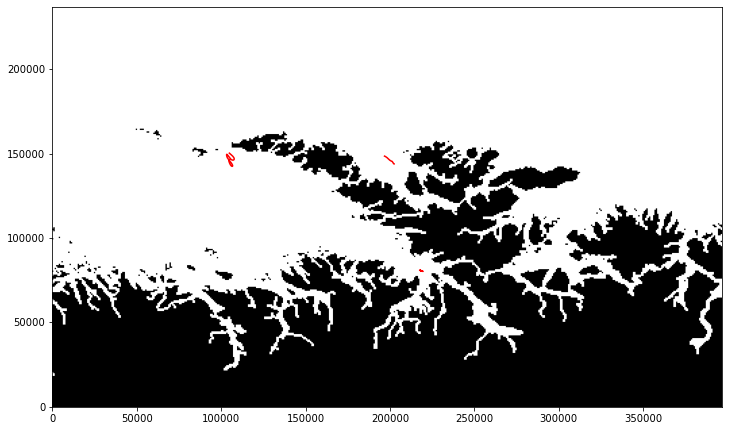

In [14]:
#Create figure
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)

#Add landmask
domain_size_x = forecast.domain_size_x
domain_size_y = forecast.domain_size_y

extent=np.array([0, domain_size_x, 0, domain_size_y]) 
ax.imshow(forecast.land_mask, origin="lower", extent=extent, cmap='binary')

#Plot drifters
for drifter_path in drifter_paths:
    for path in drifter_path:
        ax.plot(path[:,0], path[:,1], color = 'red', zorder=5)

Another alternative is using the premade function <code> GPUOcean_runDeterministic.plotAllDrifters </code> which lets you  select drift trajectories, zoom onto them, apply background(showing strength of currents), labelling etc. Below, we plot the  drifters:

/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py:431: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  v_cmap.set_bad(land_color, alpha = 1.0)


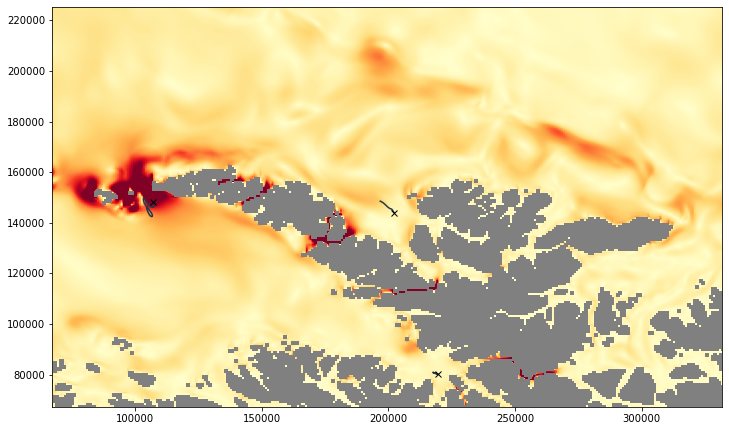

In [15]:
from gpuocean.utils import GPUOcean_runDeterministic

domain = [1400, 1900, 450, 750] # [x0,x1,y0,y1]
GPUOcean_runDeterministic.plotAllDrifters(forecast, background = True, #url and domain only needed 
                                          url = source_url, domain = domain, zoom = 1.5)  #if background is True

Zoom in on drifter 1:

/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py:431: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  v_cmap.set_bad(land_color, alpha = 1.0)


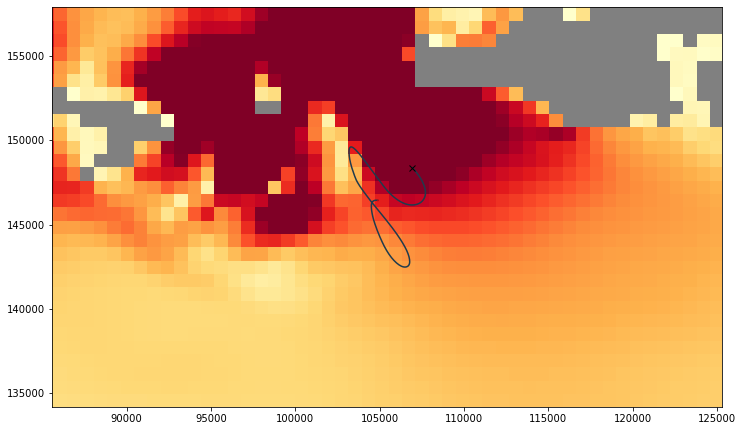

In [16]:
GPUOcean_runDeterministic.plotAllDrifters(forecast, background = True, 
                                          url = source_url, domain = domain, zoom = 10, zoom_element = 2)

## Changing Resolution

It is possible to run the simulation with a higher resolution than the original boundary- and initial data. This is done by rescaling the initialization arguments data_args with <code> NetCDFInitialization.rescaleInitialConditions</code> before passing them to the Simulator-constructor. Using data_args from above we run the simulation with double resoulution:

In [17]:
#Rescaling initial conditions
data_args_doubleres =  NetCDFInitialization.rescaleInitialConditions(data_args, scale = 2)


#Setting up simulator, observation, drifters and running as above
sim_doubleres = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args_doubleres))

observation_args_doubleres = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                                'nx': sim_doubleres.nx, 'ny': sim_doubleres.ny,
                                'domain_size_x': sim_doubleres.nx*sim_doubleres.dx,
                                'domain_size_y': sim_doubleres.ny*sim_doubleres.dy,
                                'land_mask': sim_doubleres.getLandMask()
                               }

forecast_doubleres = Observation.Observation(**observation_args_doubleres)

drifters_doubleres = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                                 boundaryConditions = sim_doubleres.boundary_conditions,
                                                                 domain_size_x = forecast_doubleres.domain_size_x,
                                                                 domain_size_y = forecast_doubleres.domain_size_y,
                                                                 gpu_stream = sim_doubleres.gpu_stream)

drifters_doubleres.setDrifterPositions(init_positions) #Same initial positions as above

#Running simulation
#Create new progress bar
progress = Common.ProgressPrinter(5)
pp = display(progress.getPrintString(0), display_id=True)

#Run simulation
for hour in range(total_hours):
    
    if hour == start_drifters_hours:                  #Attach drifters 
        sim_doubleres.attachDrifters(drifters_doubleres)
        forecast_doubleres.add_observation_from_sim(sim_doubleres)
    
    for n in range(timesteps_per_hour):    
        t = sim_doubleres.step(dt)                              #make one step forward in time
        if hour >= start_drifters_hours:               #Add positions to observation only if drifters have been attached
            forecast_doubleres.add_observation_from_sim(sim_doubleres) 
    
    #Update progress bar
    pp.update(progress.getPrintString(hour/(total_hours-1)))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


'0% [##############################] 100%. Total: 1m 3s, elapsed: 1m 3s, remaining: 0s'

## Adding Direct Wind Drift

In addition to the ocean currents, drifters at the surface are often advected directly by the wind. This is included in the simulation by specifying a <code>wind_drift_factor</code> which by default has value 0(no wind-drift). The value of this factor is typically around 0.02 or $2%$. 

The relevant wind-data is loaded together with the other boundary- and initial conditions, but needs to be extracted and passed to the DrifterCollection-object as shown below. Again we reuse data_args from above.

In [18]:
#Setting up simulator and observation as before
sim_wind = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

forecast_wind = Observation.Observation(**observation_args) #Since the simulation object is not changed(but new is made)
                                                            # the observation_args remain the same as before
        
#Creating driftercollection specifying wind-data and wind_drift_factor
drifters_wind = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, wind = data_args["wind"],
                                                          wind_drift_factor = 0.02,
                                                          boundaryConditions = sim_wind.boundary_conditions,
                                                          domain_size_x = forecast_wind.domain_size_x,
                                                          domain_size_y = forecast_wind.domain_size_y,
                                                          gpu_stream = sim_wind.gpu_stream)

drifters_wind.setDrifterPositions(init_positions) #Same initial positions as above

#Running simulation
#Create new progress bar
progress = Common.ProgressPrinter(5)
pp = display(progress.getPrintString(0), display_id=True)

#Run simulation
for hour in range(total_hours):
    
    if hour == start_drifters_hours:                  #Attach drifters 
        sim_wind.attachDrifters(drifters_wind)
        forecast_wind.add_observation_from_sim(sim_wind)
    
    for n in range(timesteps_per_hour):    
        t = sim_wind.step(dt)                              #make one step forward in time
        if hour >= start_drifters_hours:               #Add positions to observation only if drifters have been attached
            forecast_wind.add_observation_from_sim(sim_wind) 
    
    #Update progress bar
    pp.update(progress.getPrintString(hour/(total_hours-1)))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


'0% [##############################] 100%. Total: 32s, elapsed: 32s, remaining: 0s'

## Comparing trajectories

We can compare the different runs by creating a common canvas and plotting the differens results on the same ax by providing ax as an agrument to <code>plotAllDrifters</code>. Here, we compare the first drifter:

/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py:431: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  v_cmap.set_bad(land_color, alpha = 1.0)


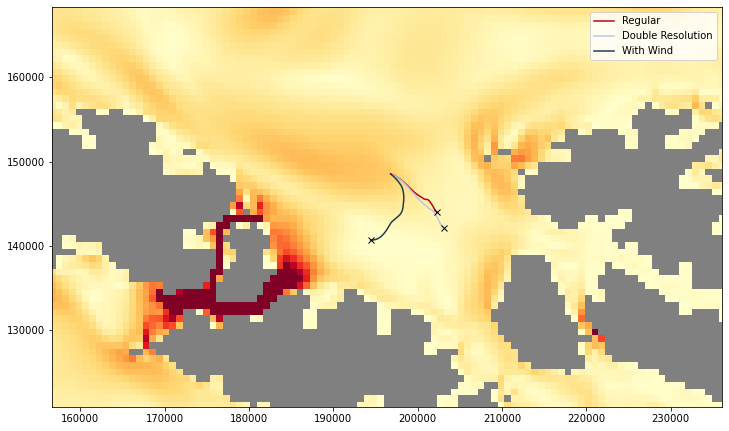

In [19]:
ax = GPUOcean_runDeterministic.createForecastCanvas(forecast_wind,background = True, url= source_url,
                                                    domain = domain, zoom= 5)
GPUOcean_runDeterministic.plotAllDrifters(forecast, drifter_ids = [0], ax = ax, color_id = 0, label="Regular")
GPUOcean_runDeterministic.plotAllDrifters(forecast_doubleres, drifter_ids = [0], ax = ax, color_id = 1, label= "Double Resolution") 
GPUOcean_runDeterministic.plotAllDrifters(forecast_wind, drifter_ids = [0], ax = ax, color_id = 2, label = "With Wind") 
ax.legend()

/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py:431: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  v_cmap.set_bad(land_color, alpha = 1.0)


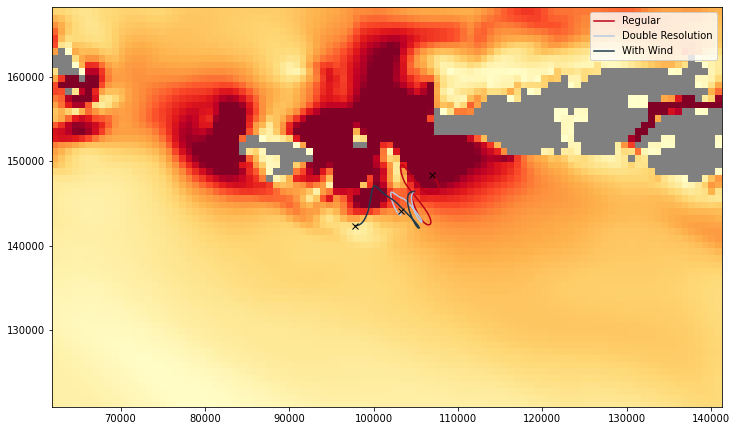

In [20]:
ax = GPUOcean_runDeterministic.createForecastCanvas(forecast_wind,background = True, url= source_url,
                                                    domain = domain, zoom= 5, zoom_element=2)
GPUOcean_runDeterministic.plotAllDrifters(forecast, drifter_ids = [2], ax = ax, color_id = 0, label="Regular")
GPUOcean_runDeterministic.plotAllDrifters(forecast_doubleres, drifter_ids = [2], ax = ax, color_id = 1, label= "Double Resolution") 
GPUOcean_runDeterministic.plotAllDrifters(forecast_wind, drifter_ids = [2], ax = ax, color_id = 2, label = "With Wind") 
ax.legend()

## Data from Norfjords160

Norfjords160 provides higher-resolution data for certain areas along the coast. As the file format is different, an extra argument <code>norkyst = False</code> needs to be passed to <code>NetCDFInitialization.getInitialConditions()</code>. The indices defining the domain are also different as the covered area is different. Otherwise, everything is the same.

Finally, the function <code> GPUOcean_runDeterministic.simulate_gpuocean_deterministic </code> lets you run simulations like the ones above with one function call. It takes in a source_url, domain($[x_0,x_1,y_0,y_1]$), initial positions, sim_args and optional wind-drift,scaling factors and boolean parameter for norfjords-data and returns an Observation object with the forecast. A small example that also demonstrated the Norfjords160-data is given below. See OpendriftParcels/Compare_Example.ipynb for more.

In [21]:
from importlib import reload
reload(GPUOcean_runDeterministic)
#local file path
norfjords160 = '/home/johanna/gpu-ocean/gpu_ocean/papers/MPI_SIR/netcdf_cache/NorFjords160/A10/norfjords_160m_his.nc4_2019071601-2019071700'

assert os.path.isfile(norfjords160), "NorFjord160 data is not public, and you therefore need to modify the local path if you have the data available"

#Using xygpuocean2lonlat, we find the initail positions of the first drifter in lon/lat coordinates
initlon, initlat = GPUOcean_runDeterministic.xygpuocean2lonlat(source_url,196790, 148550, 1400, 450)
print('lon:', initlon, ", lat: ", initlat)

#Use these to find initial positions and define area for Norfjords160 data
#Set norkyst= False
xinit, yinit, x0, x1, y0, y1 = GPUOcean_runDeterministic.initlonlat2initgpuocean(norfjords160, initlon, initlat, 
                                                       norkyst = False, num_cells_x = 400, num_cells_y = 250)
domain = [x0,x1,y0,y1]

#Set sim_args and run norfjords forecast
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
     }
norfjords_forecast = GPUOcean_runDeterministic.simulate_gpuocean_deterministic(norfjords160, domain, xinit, yinit, sim_args = sim_args,
                                                    norkyst_data = False)

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_16921/2903230176.py", line 6, in <module>
    assert os.path.isfile(norfjords160), "NorFjord160 data is not public, and you therefore need to modify the local path if you have the data available"
AssertionError: NorFjord160 data is not public, and you therefore need to modify the local path if you have the data available


AssertionError: NorFjord160 data is not public, and you therefore need to modify the local path if you have the data available

In [ ]:
GPUOcean_runDeterministic.plotAllDrifters(norfjords_forecast, background = True, url= norfjords160, domain = domain,
                                           zoom = 1, color_id = 0,  label = "norfjords_forecast")

## Comparing simulations with different domains

To directly compare trajectories found using initial data from Norfjords160 and Norkyst800, they need to be within the same coordinate system, given in distance in m from the same reference point. The function <code> GPUOcean_runDeterministic.norkyst2norfjords</code> takes in urls to norkyst and norfjords data as well as both observations and x0, y0 -values of the domains. It returns a new observation with the trajectories from the observation based on norkyst data, but placed within the same reference system as the observation based on norfjords-data. These can then be plotted together as before.

In [ ]:
#Printing norfjords-domain:
print("Domain norfjords_forecast:\nx0: ",x0,', x1: ',x1,', y0: ', y0,', y1: ',y1)

In [ ]:
norkyst_new = GPUOcean_runDeterministic.norkyst2norfjords(norfjords_obs = norfjords_forecast, norkyst_obs = forecast, 
                                                            norfjords_url = norfjords160, norkyst_url = source_url, 
                                                            norfjords_x0 = 1038, norfjords_y0 = 715, 
                                                            norkyst_x0 = 1400, norkyst_y0 = 450)

In [ ]:
ax = GPUOcean_runDeterministic.createForecastCanvas(norfjords_forecast,background = True, url= norfjords160,
                                                    domain = domain, zoom= 1, zoom_element=0)
GPUOcean_runDeterministic.plotAllDrifters(norfjords_forecast, ax = ax, color_id = 0, label="Norfjords160")
GPUOcean_runDeterministic.plotAllDrifters(norkyst_new, ax = ax,drifter_ids =[0] , color_id = 2, label="Norkyst800")
ax.legend()